# Exploratory Data Analysis (EDA)
# Office Apocalypse Algorithm: NYC Office Building Vacancy Prediction

**Author:** [Your Name]  
**Date:** October 2025  
**Course:** [Course Name]  

---

## Project Overview

This notebook performs comprehensive Exploratory Data Analysis (EDA) for the Office Apocalypse Algorithm project. The goal is to predict office building vacancy in NYC using multiple data sources.

### Data Sources
1. **PLUTO (Primary Land Use Tax Lot Output)**: Universe of NYC buildings
2. **ACRIS (Automated City Register Information System)**: Property transactions
3. **MTA Subway Ridership**: Transportation demand indicators
4. **Business Registry**: Economic activity data
5. **Vacant Storefronts**: Neighborhood distress signals

### Analysis Objectives
- Understand data structure and quality
- Identify missing values and data issues
- Explore distributions and correlations
- Generate insights for feature engineering
- Assess data readiness for modeling

## 1. Setup and Data Loading

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Project paths
DATA_DIR = Path("../data/raw")
OUTPUT_DIR = Path("../data/processed")
OUTPUT_DIR.mkdir(exist_ok=True)

print("Environment setup complete")

Environment setup complete


In [2]:
# Load datasets with error handling
def load_dataset(name, file_path, sample_size=None):
    """Load dataset with basic info"""
    try:
        if sample_size:
            df = pd.read_csv(file_path, nrows=sample_size, low_memory=False)
            print(f"✓ Loaded {name}: {len(df)} rows (sampled), {len(df.columns)} columns")
        else:
            df = pd.read_csv(file_path, low_memory=False)
            print(f"✓ Loaded {name}: {len(df)} rows, {len(df.columns)} columns")
        return df
    except FileNotFoundError:
        print(f"✗ {name} not found at {file_path}")
        return None
    except Exception as e:
        print(f"✗ Error loading {name}: {e}")
        return None

# Load all datasets
datasets = {}

# PLUTO - Full dataset (manageable size)
datasets['pluto'] = load_dataset("PLUTO", DATA_DIR / "pluto_25v2_1.csv")

# ACRIS - Sample for EDA (22M rows is too large)
datasets['acris'] = load_dataset("ACRIS", DATA_DIR / "ACRIS_-_Real_Property_Legals_20250915.csv", sample_size=50000)

# MTA Ridership
datasets['mta'] = load_dataset("MTA Ridership", DATA_DIR / "MTA_Subway_Hourly_Ridership__2020-2024.csv")

# Business Registry
datasets['business'] = load_dataset("Business Registry", DATA_DIR / "business_registry.csv")

# Vacant Storefronts
datasets['vacant'] = load_dataset("Vacant Storefronts", DATA_DIR / "Storefronts_Reported_Vacant_or_Not_20250915.csv")

print("\nData loading complete!")

✓ Loaded PLUTO: 857736 rows, 92 columns
✓ Loaded ACRIS: 50000 rows (sampled), 14 columns


✗ Error loading MTA Ridership: Error tokenizing data. C error: out of memory


✓ Loaded Business Registry: 66425 rows, 31 columns


✓ Loaded Vacant Storefronts: 348297 rows, 27 columns

Data loading complete!


## 2. Data Structure Overview

In [3]:
# Display basic information for each dataset
for name, df in datasets.items():
    if df is not None:
        print(f"\n=== {name.upper()} DATASET ===")
        print(f"Shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        print("\nData Types:")
        print(df.dtypes)
        print("\nFirst 3 rows:")
        display(df.head(3))


=== PLUTO DATASET ===
Shape: (857736, 92)
Columns: ['borough', 'block', 'lot', 'cd', 'bct2020', 'bctcb2020', 'ct2010', 'cb2010', 'schooldist', 'council', 'zipcode', 'firecomp', 'policeprct', 'healthcenterdistrict', 'healtharea', 'sanitboro', 'sanitdistrict', 'sanitsub', 'address', 'zonedist1', 'zonedist2', 'zonedist3', 'zonedist4', 'overlay1', 'overlay2', 'spdist1', 'spdist2', 'spdist3', 'ltdheight', 'splitzone', 'bldgclass', 'landuse', 'easements', 'ownertype', 'ownername', 'lotarea', 'bldgarea', 'comarea', 'resarea', 'officearea', 'retailarea', 'garagearea', 'strgearea', 'factryarea', 'otherarea', 'areasource', 'numbldgs', 'numfloors', 'unitsres', 'unitstotal', 'lotfront', 'lotdepth', 'bldgfront', 'bldgdepth', 'ext', 'proxcode', 'irrlotcode', 'lottype', 'bsmtcode', 'assessland', 'assesstot', 'exempttot', 'yearbuilt', 'yearalter1', 'yearalter2', 'histdist', 'landmark', 'builtfar', 'residfar', 'commfar', 'facilfar', 'borocode', 'bbl', 'condono', 'tract2010', 'xcoord', 'ycoord', 'zonem

borough       object
block          int64
lot            int64
cd           float64
bct2020      float64
              ...   
version       object
dcpedited     object
latitude     float64
longitude    float64
notes        float64
Length: 92, dtype: object

First 3 rows:


,borough,block,lot,cd,bct2020,bctcb2020,ct2010,cb2010,schooldist,council,...,appbbl,appdate,plutomapid,firm07_flag,pfirm15_flag,version,dcpedited,latitude,longitude,notes
0,QN,6421,38,407.0,4083700.0,4.083700e+10,837.0,3005.0,25.0,20.0,...,NaN,NaN,1,NaN,NaN,25v2.1,NaN,40.743955,-73.819475,NaN
1,QN,5175,20,407.0,4083700.0,4.083700e+10,837.0,3000.0,25.0,20.0,...,NaN,NaN,1,NaN,NaN,25v2.1,NaN,40.744709,-73.819221,NaN
2,QN,5173,111,407.0,4083700.0,4.083700e+10,837.0,1001.0,25.0,20.0,...,NaN,NaN,1,NaN,NaN,25v2.1,NaN,40.745663,-73.819727,NaN



=== ACRIS DATASET ===
Shape: (50000, 14)
Columns: ['DOCUMENT ID', 'RECORD TYPE', 'BOROUGH', 'BLOCK', 'LOT', 'EASEMENT', 'PARTIAL LOT', 'AIR RIGHTS', 'SUBTERRANEAN RIGHTS', 'PROPERTY TYPE', 'STREET NUMBER', 'STREET NAME', 'UNIT', 'GOOD THROUGH DATE']

Data Types:
DOCUMENT ID            object
RECORD TYPE            object
BOROUGH                 int64
BLOCK                   int64
LOT                     int64
EASEMENT               object
PARTIAL LOT            object
AIR RIGHTS             object
SUBTERRANEAN RIGHTS    object
PROPERTY TYPE          object
STREET NUMBER          object
STREET NAME            object
UNIT                   object
GOOD THROUGH DATE      object
dtype: object

First 3 rows:


,DOCUMENT ID,RECORD TYPE,BOROUGH,BLOCK,LOT,EASEMENT,PARTIAL LOT,AIR RIGHTS,SUBTERRANEAN RIGHTS,PROPERTY TYPE,STREET NUMBER,STREET NAME,UNIT,GOOD THROUGH DATE
0,2025081100218003,L,3,1973,1103,N,E,N,N,SC,56,QUINCY STREET,3,08/31/2025
1,2025081100289001,L,3,6121,3,N,E,N,N,SP,149,MARINE AVE,5M,08/31/2025
2,2025081400823001,L,1,1183,29,N,E,N,N,SP,243,WEST END AVENUE,407,08/31/2025



=== BUSINESS DATASET ===
Shape: (66425, 31)
Columns: ['License Number', 'Business Name', 'DBA/Trade Name', 'Business Unique ID', 'Business Category', 'License Type', 'License Status', 'Initial Issuance Date', 'Expiration Date', 'Details', 'Contact Phone', 'Address Type', 'Building Number', 'Street1', 'Street2', 'Street3', 'Unit Type', 'Apt/Suite', 'City', 'State', 'ZIP Code', 'Borough', 'Community Board', 'Council District', 'BIN', 'BBL', 'NTA', 'Census Block (2010)', 'Census Tract (2010)', 'Latitude', 'Longitude']

Data Types:
License Number            object
Business Name             object
DBA/Trade Name            object
Business Unique ID        object
Business Category         object
License Type              object
License Status            object
Initial Issuance Date     object
Expiration Date           object
Details                   object
Contact Phone             object
Address Type              object
Building Number           object
Street1                   object
Str

,License Number,Business Name,DBA/Trade Name,Business Unique ID,Business Category,License Type,License Status,Initial Issuance Date,Expiration Date,Details,...,Borough,Community Board,Council District,BIN,BBL,NTA,Census Block (2010),Census Tract (2010),Latitude,Longitude
0,2123226-DCWP,Denis Spedalieri,NaN,BA-1703334-2024,Sightseeing Guide,Individual,Active,08/01/2024,03/31/2026,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2089275-DCA,SANJAY'S VARIETY STORE INC.,NaN,BA-1500311-2022,Secondhand Dealer - General,Premises,Expired,08/07/2019,07/31/2023,NaN,...,Queens,412.0,23.0,4222128.0,4.104460e+09,QN07,1007.0,482.0,40.71209,-73.769333
2,2123284-DCWP,Gayla Hibner,NaN,BA-1698945-2024,Sightseeing Guide,Individual,Active,08/05/2024,03/31/2026,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



=== VACANT DATASET ===
Shape: (348297, 27)
Columns: ['Filing Due Date', 'Reporting Year', 'Borough Block Lot', 'Property Street Address or Storefront Address', 'Borough', 'Zip Code', 'Sold Date', 'Vacant on 12/31', 'Construction Reported', 'Vacant 6/30 or Date Sold', 'Primary Business Activity', 'Expiration date of the most recent lease', 'Property Number', 'Property Street', 'Unit', 'Borough1', 'Postcode', 'Latitude', 'Longitude', 'Lat/Long', 'Community Board', 'Council District', 'Census Tract', 'BIN', 'BBL', 'NTA', 'NTA Neighborhood']

Data Types:
Filing Due Date                                   object
Reporting Year                                    object
Borough Block Lot                                  int64
Property Street Address or Storefront Address     object
Borough                                           object
Zip Code                                          object
Sold Date                                         object
Vacant on 12/31                            

,Filing Due Date,Reporting Year,Borough Block Lot,Property Street Address or Storefront Address,Borough,Zip Code,Sold Date,Vacant on 12/31,Construction Reported,Vacant 6/30 or Date Sold,...,Latitude,Longitude,Lat/Long,Community Board,Council District,Census Tract,BIN,BBL,NTA,NTA Neighborhood
0,06/03/2024,2023,5051430020,3996 AMBOY ROAD,STATEN ISLAND,10308,NaN,NaN,N,NaN,...,40.550136,-74.150602,POINT (-74.1506024 40.5501364),503.0,51.0,013203,5065713,5051430020,SI0302,Great Kills-Eltingville
1,06/03/2024,2023,5005430010,271 BROAD STREET,STATEN ISLAND,10304,NaN,YES,N,NaN,...,40.623625,-74.083549,POINT (-74.0835487 40.6236254),501.0,49.0,002100,5166592,5005430010,SI0102,Tompkinsville-Stapleton-Clifton-Fox Hills
2,06/03/2024,2023,5051430017,3 NELSON AVENUE,STATEN ISLAND,10308,NaN,NaN,N,NaN,...,40.549870,-74.150609,POINT (-74.150609 40.5498701),503.0,51.0,013203,5065711,5051430017,SI0302,Great Kills-Eltingville


## 3. Missing Values Analysis


=== PLUTO - MISSING VALUES ===


,Missing Count,Missing %
spdist3,857736,100.000000
notes,857736,100.000000
zonedist4,857724,99.998601
overlay2,857551,99.978432
zonedist3,857519,99.974701
...,...,...
yearalter1,356,0.041505
exempttot,356,0.041505
bsmtcode,356,0.041505
yearalter2,356,0.041505


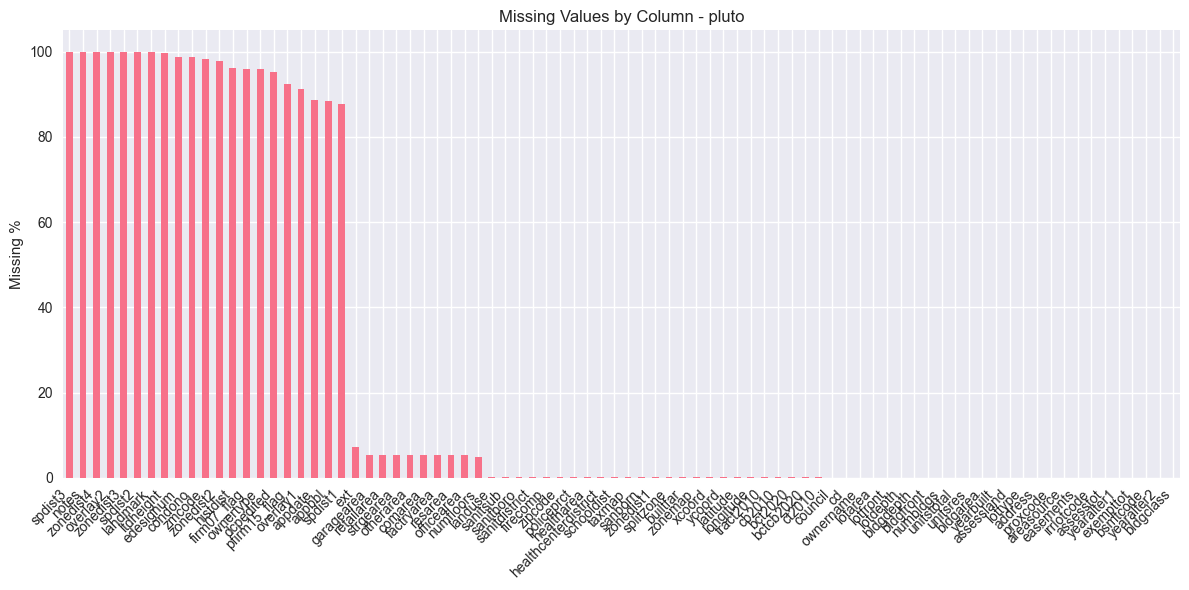


=== ACRIS - MISSING VALUES ===


,Missing Count,Missing %
UNIT,24447,48.894
STREET NUMBER,674,1.348
STREET NAME,93,0.186


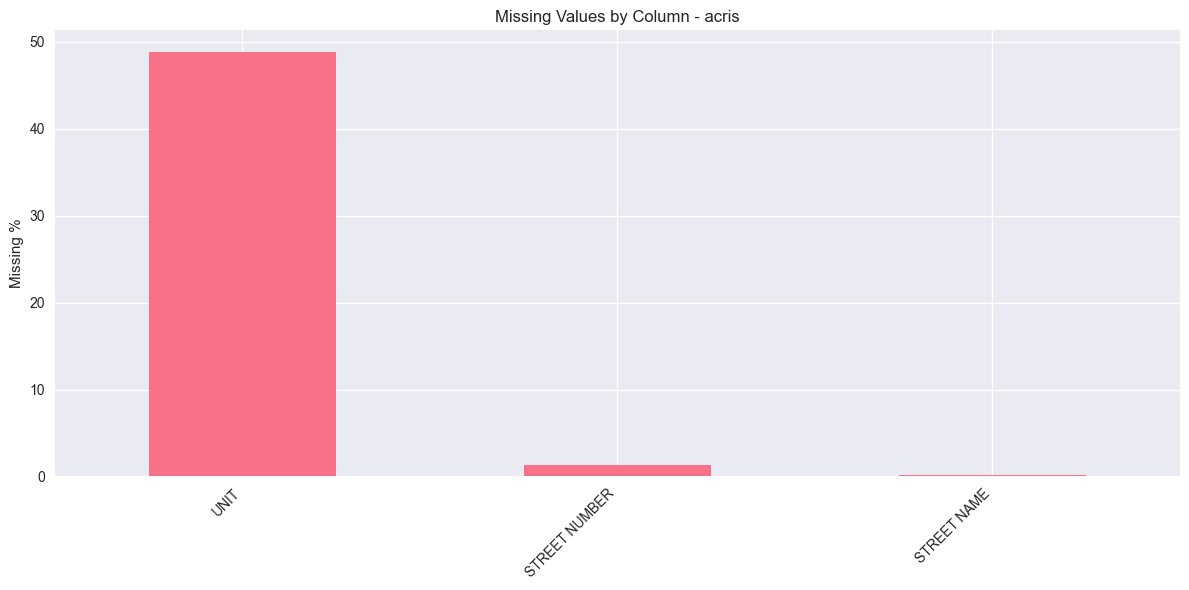


=== BUSINESS - MISSING VALUES ===


,Missing Count,Missing %
Street2,66425,100.000000
Street3,66422,99.995484
Details,58800,88.520888
DBA/Trade Name,56953,85.740309
Apt/Suite,56890,85.645465
Unit Type,56499,85.056831
BIN,24709,37.198344
BBL,24709,37.198344
Census Block (2010),24346,36.651863
NTA,24345,36.650358


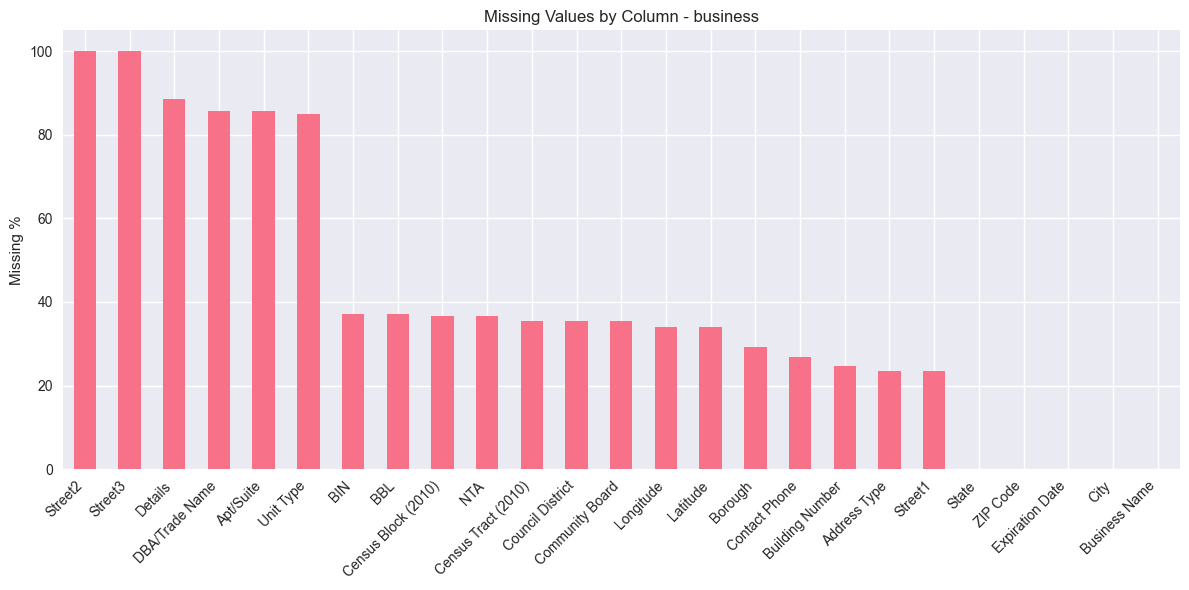


=== VACANT - MISSING VALUES ===


,Missing Count,Missing %
Sold Date,347949,99.900085
Construction Reported,341301,97.991369
Vacant 6/30 or Date Sold,335186,96.235684
Unit,311977,89.572118
Expiration date of the most recent lease,280978,80.671955
Primary Business Activity,7036,2.020115
Latitude,6003,1.723529
Longitude,6003,1.723529
Lat/Long,6003,1.723529
Zip Code,3298,0.946893


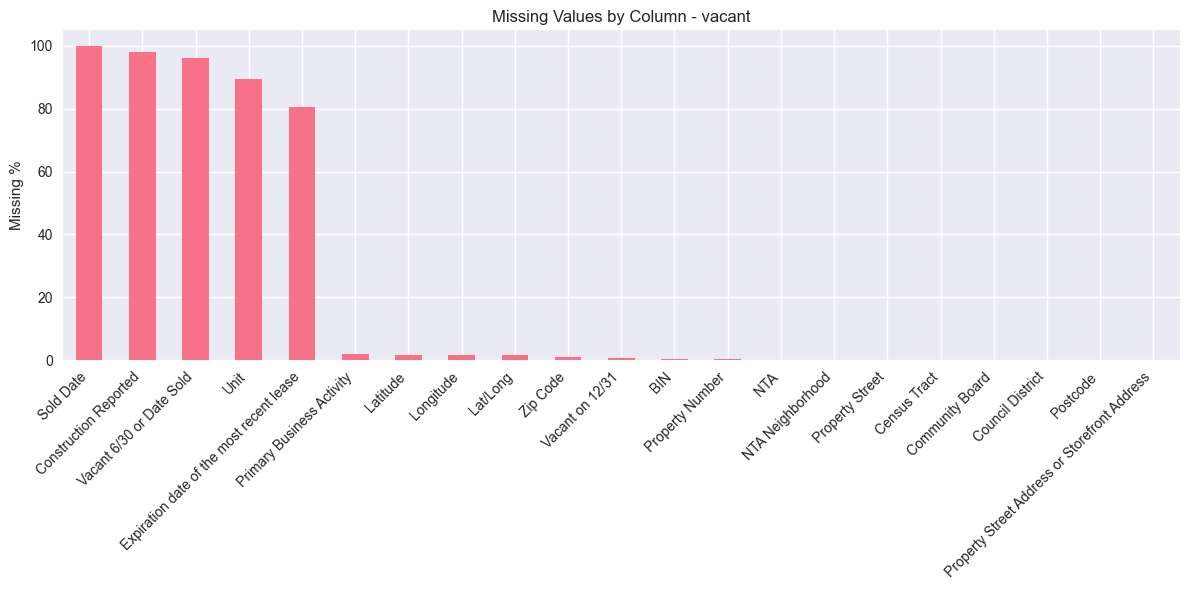

In [4]:
# Analyze missing values for each dataset
def analyze_missing_values(df, name):
    """Analyze missing values in dataset"""
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    
    missing_df = pd.DataFrame({
        'Missing Count': missing,
        'Missing %': missing_pct
    }).sort_values('Missing %', ascending=False)
    
    # Filter to show only columns with missing values
    missing_df = missing_df[missing_df['Missing Count'] > 0]
    
    if len(missing_df) > 0:
        print(f"\n=== {name.upper()} - MISSING VALUES ===")
        display(missing_df)
        
        # Visualize missing values
        plt.figure(figsize=(12, 6))
        missing_df['Missing %'].plot(kind='bar')
        plt.title(f'Missing Values by Column - {name}')
        plt.ylabel('Missing %')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print(f"\n=== {name.upper()} - NO MISSING VALUES ===")

# Analyze missing values for all datasets
for name, df in datasets.items():
    if df is not None:
        analyze_missing_values(df, name)

## 4. PLUTO Dataset Deep Dive

PLUTO is our primary dataset containing information about all NYC buildings.

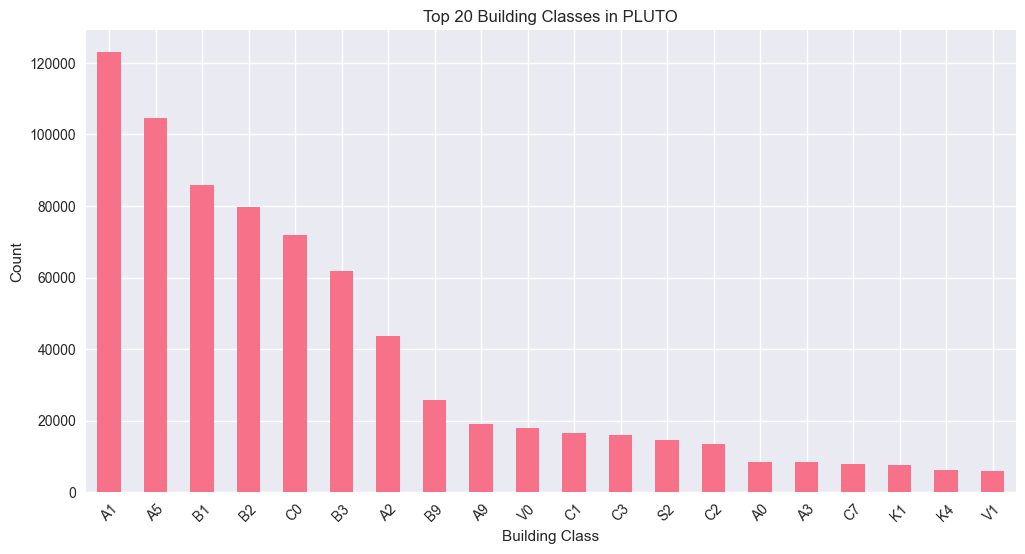


Office buildings: 7191
Percentage of total buildings: 0.84%


In [5]:
# Focus on PLUTO dataset
pluto = datasets['pluto']
if pluto is not None:
    # Building type distribution
    plt.figure(figsize=(12, 6))
    pluto['bldgclass'].value_counts().head(20).plot(kind='bar')
    plt.title('Top 20 Building Classes in PLUTO')
    plt.xlabel('Building Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()
    
    # Office buildings specifically
    office_buildings = pluto[pluto['bldgclass'].str.startswith('O', na=False)]
    print(f"\nOffice buildings: {len(office_buildings)}")
    print(f"Percentage of total buildings: {len(office_buildings)/len(pluto)*100:.2f}%")

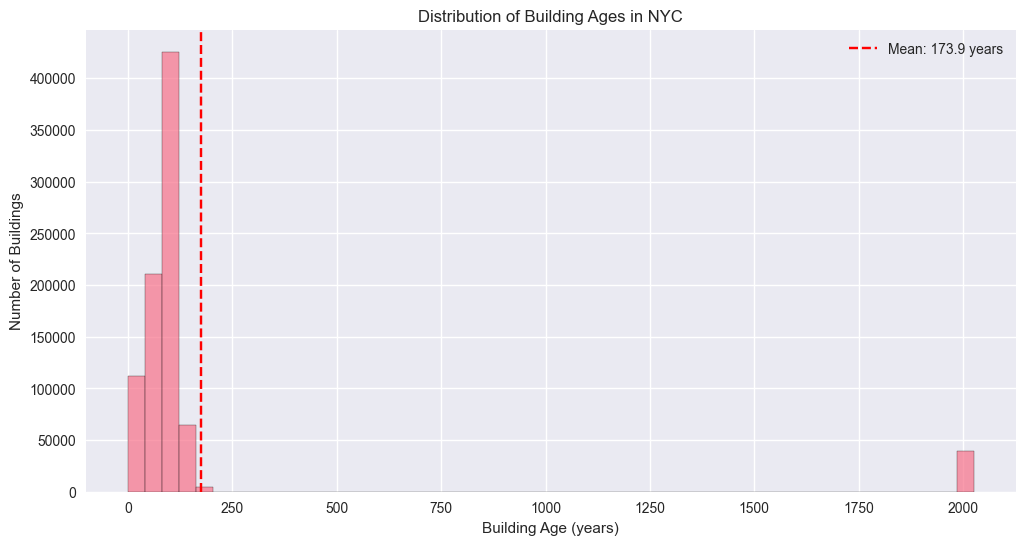


Building Age Statistics:
count    857380.000000
mean        173.852464
std         410.034577
min           0.000000
25%          65.000000
50%          95.000000
75%         105.000000
max        2025.000000
Name: building_age, dtype: float64


In [6]:
# Building age distribution
if pluto is not None:
    current_year = 2025
    pluto['building_age'] = current_year - pluto['yearbuilt']
    
    plt.figure(figsize=(12, 6))
    plt.hist(pluto['building_age'].dropna(), bins=50, alpha=0.7, edgecolor='black')
    plt.title('Distribution of Building Ages in NYC')
    plt.xlabel('Building Age (years)')
    plt.ylabel('Number of Buildings')
    plt.axvline(pluto['building_age'].mean(), color='red', linestyle='--', label=f'Mean: {pluto["building_age"].mean():.1f} years')
    plt.legend()
    plt.show()
    
    print(f"\nBuilding Age Statistics:")
    print(pluto['building_age'].describe())

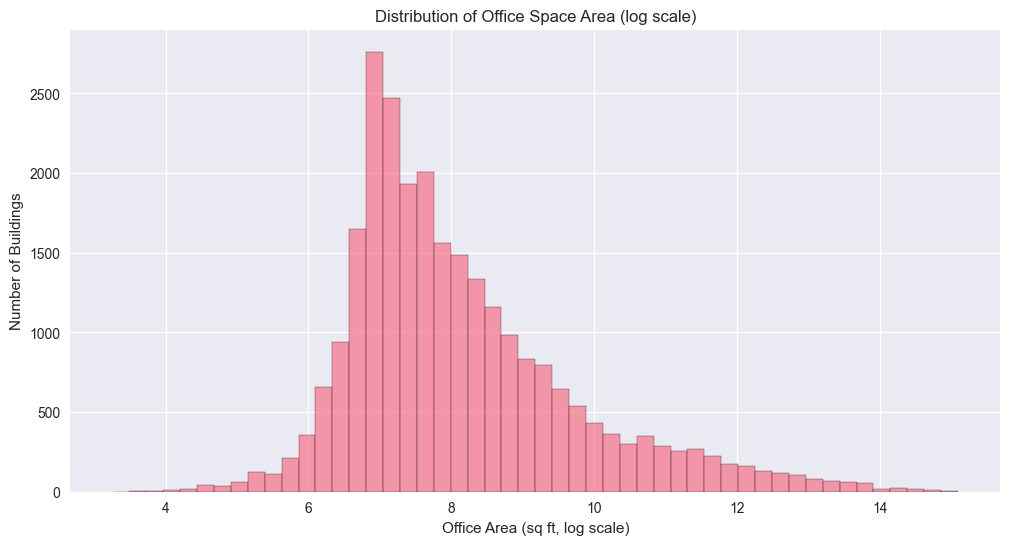


Office Space Statistics:
count    2.623500e+04
mean     2.565923e+04
std      1.227637e+05
min      2.500000e+01
25%      1.100000e+03
50%      2.250000e+03
75%      7.200000e+03
max      3.583167e+06
Name: officearea, dtype: float64


In [7]:
# Office space analysis
if pluto is not None:
    office_data = pluto[pluto['officearea'] > 0]
    
    plt.figure(figsize=(12, 6))
    plt.hist(np.log1p(office_data['officearea']), bins=50, alpha=0.7, edgecolor='black')
    plt.title('Distribution of Office Space Area (log scale)')
    plt.xlabel('Office Area (sq ft, log scale)')
    plt.ylabel('Number of Buildings')
    plt.show()
    
    print(f"\nOffice Space Statistics:")
    print(office_data['officearea'].describe())

## 5. Geographic Analysis

Visualizing the spatial distribution of buildings and office space.

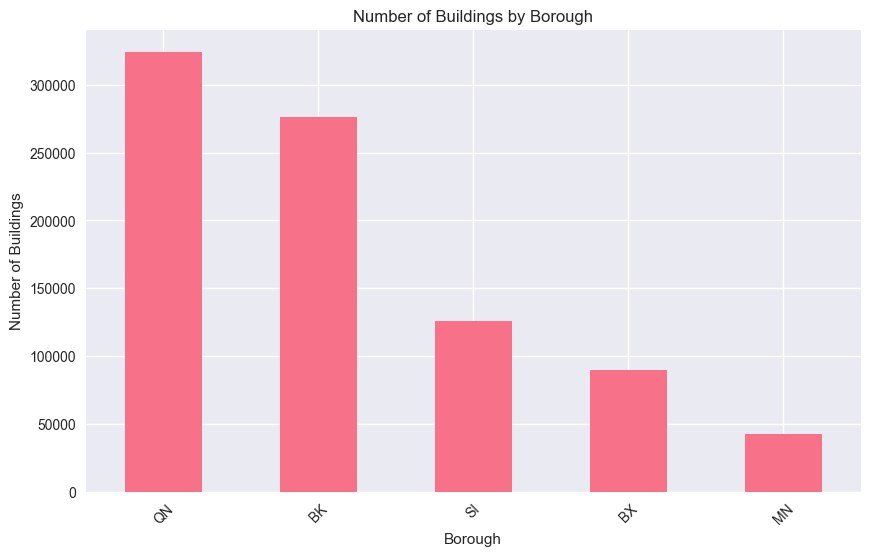

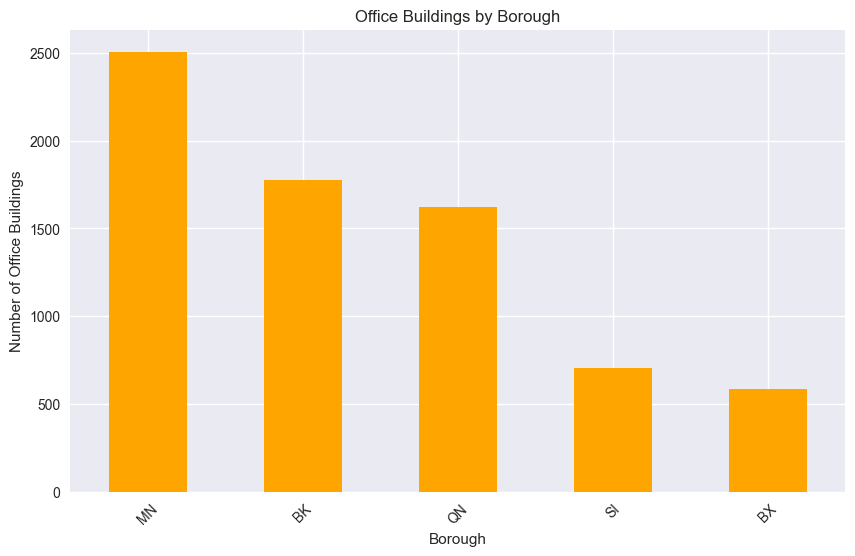

In [8]:
# Geographic distribution by borough
if pluto is not None:
    borough_counts = pluto['borough'].value_counts()
    
    plt.figure(figsize=(10, 6))
    borough_counts.plot(kind='bar')
    plt.title('Number of Buildings by Borough')
    plt.xlabel('Borough')
    plt.ylabel('Number of Buildings')
    plt.xticks(rotation=45)
    plt.show()
    
    # Office buildings by borough
    office_by_borough = pluto[pluto['bldgclass'].str.startswith('O', na=False)]['borough'].value_counts()
    
    plt.figure(figsize=(10, 6))
    office_by_borough.plot(kind='bar', color='orange')
    plt.title('Office Buildings by Borough')
    plt.xlabel('Borough')
    plt.ylabel('Number of Office Buildings')
    plt.xticks(rotation=45)
    plt.show()

## 6. ACRIS Transaction Analysis

Analyzing property transaction patterns that may indicate financial distress.

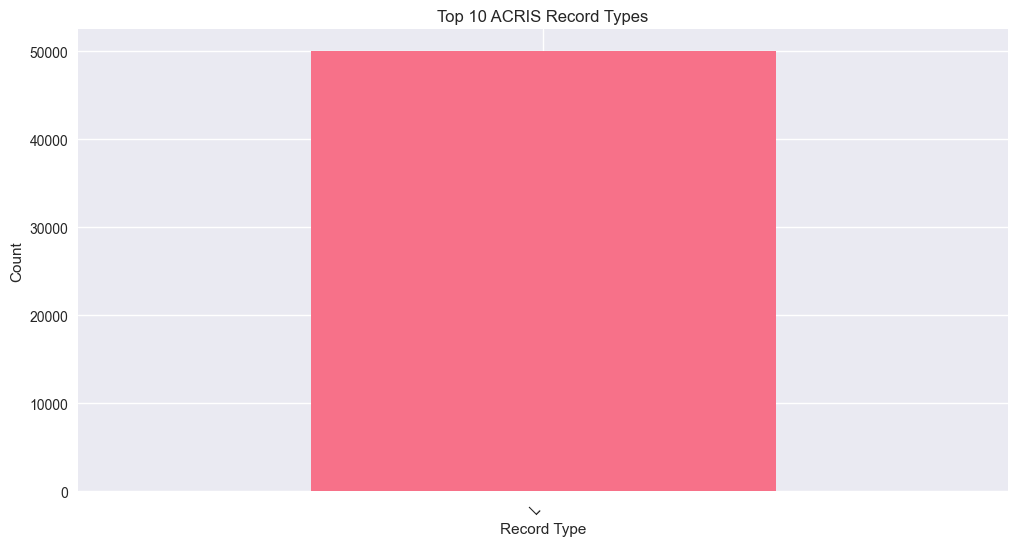

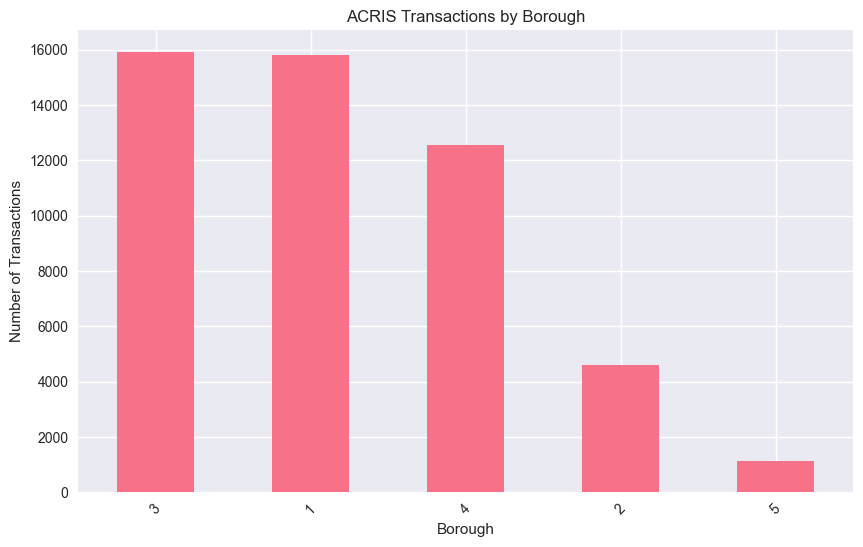

In [9]:
# ACRIS analysis
acris = datasets['acris']
if acris is not None:
    # Transaction types
    plt.figure(figsize=(12, 6))
    acris['RECORD TYPE'].value_counts().head(10).plot(kind='bar')
    plt.title('Top 10 ACRIS Record Types')
    plt.xlabel('Record Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
    # Borough distribution
    plt.figure(figsize=(10, 6))
    acris['BOROUGH'].value_counts().plot(kind='bar')
    plt.title('ACRIS Transactions by Borough')
    plt.xlabel('Borough')
    plt.ylabel('Number of Transactions')
    plt.xticks(rotation=45)
    plt.show()

## 7. Business Registry Analysis

Understanding economic activity patterns.

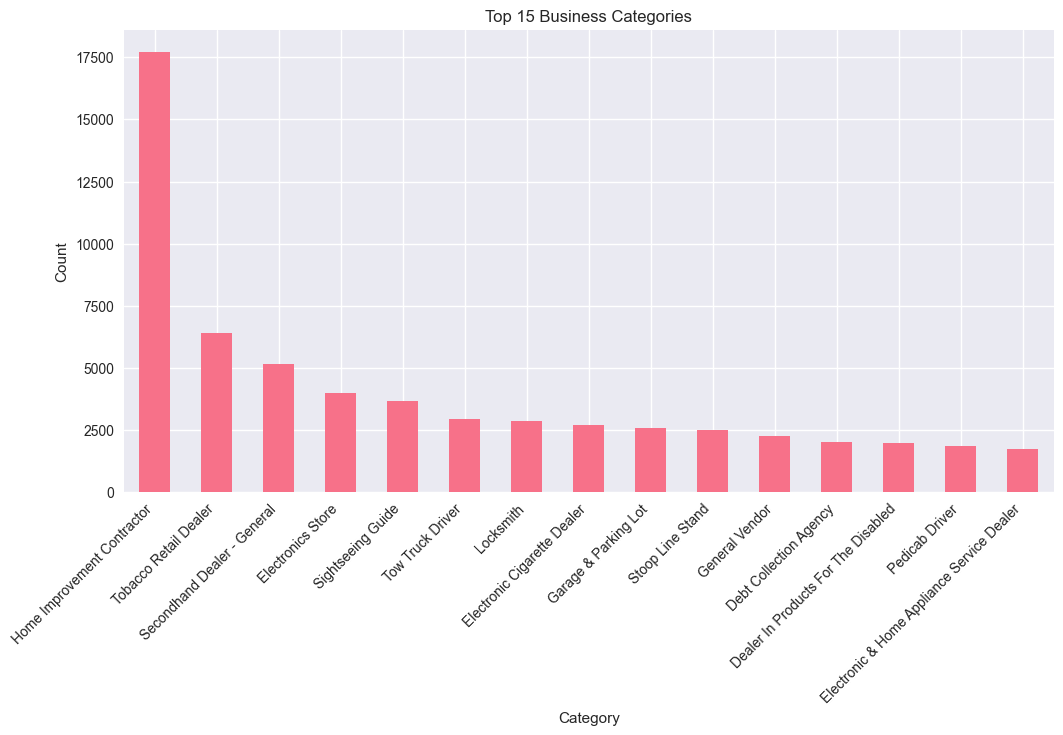

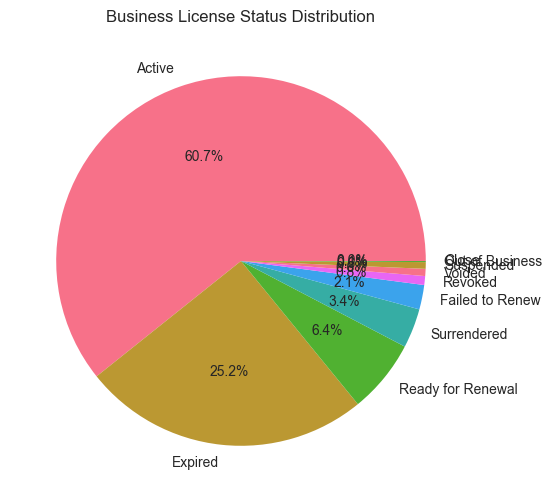

In [10]:
# Business registry analysis
business = datasets['business']
if business is not None:
    # Business categories
    plt.figure(figsize=(12, 6))
    business['Business Category'].value_counts().head(15).plot(kind='bar')
    plt.title('Top 15 Business Categories')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
    # Business status
    plt.figure(figsize=(8, 6))
    business['License Status'].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title('Business License Status Distribution')
    plt.ylabel('')
    plt.show()

## 8. Correlation Analysis

Exploring relationships between key variables in PLUTO data.

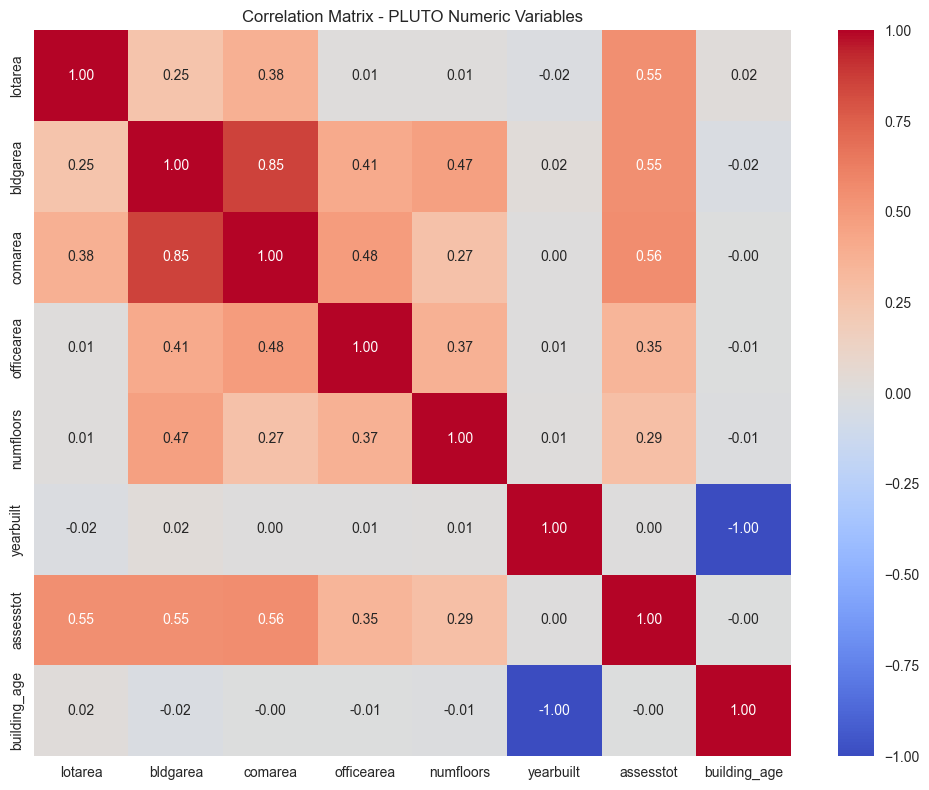


Correlations with Office Area:
officearea      1.000000
comarea         0.484918
bldgarea        0.408190
numfloors       0.367665
assesstot       0.349697
lotarea         0.013415
yearbuilt       0.005581
building_age   -0.005581
Name: officearea, dtype: float64


In [11]:
# Correlation analysis for PLUTO
if pluto is not None:
    # Select numeric columns for correlation
    numeric_cols = ['lotarea', 'bldgarea', 'comarea', 'officearea', 'numfloors', 
                   'yearbuilt', 'assesstot', 'building_age']
    
    # Filter to columns that exist
    available_cols = [col for col in numeric_cols if col in pluto.columns]
    
    corr_matrix = pluto[available_cols].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Correlation Matrix - PLUTO Numeric Variables')
    plt.tight_layout()
    plt.show()
    
    # Focus on office-related correlations
    office_corr = corr_matrix['officearea'].sort_values(ascending=False)
    print("\nCorrelations with Office Area:")
    print(office_corr)

## 9. Key Insights and Next Steps

### Summary of Findings

1. **Data Quality**: [Summary of missing values and data issues]

2. **Building Distribution**: [Key statistics about NYC buildings]

3. **Office Space**: [Insights about office buildings and vacancy indicators]

4. **Geographic Patterns**: [Borough and neighborhood insights]

5. **Economic Indicators**: [Business activity and transaction patterns]

### Recommendations for Feature Engineering

- [List key features to create]
- [Data preprocessing needs]
- [Potential target variables]

### Next Steps

1. Address data quality issues identified
2. Create integrated dataset with all sources
3. Develop feature engineering pipeline
4. Build and validate predictive models